In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-cp7mb68x
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-cp7mb68x
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import time

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from zipfile import ZipFile
file_name = "final_B_C.zip"
with ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
    print('Done!')


Done!


In [ ]:
path = "final_B_C/"
trainA, trainB, testA, testB = "trainA", "trainB", "testA","testB"
trainA = [os.path.join(path, trainA) + "/" + i for i in os.listdir(path + trainA)]
trainB = [os.path.join(path, trainB) + "/" +i for i in  os.listdir(path + trainB)]
testA = [os.path.join(path, testA) + "/" +i for i in os.listdir(path + testA)]
testB = [os.path.join(path, testB) + "/" +i for i in os.listdir(path + testB)]


In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

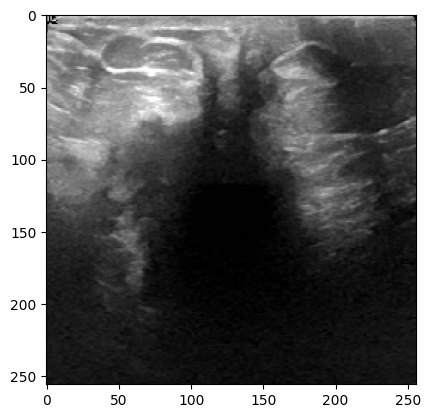

In [ ]:
image = load(trainA[0])
plt.imshow(image/255.0)

In [ ]:
def random_crop(image):
    return tf.image.random_crop(image, size = [256,256,3],)

In [ ]:
def normalize(image):
    return (image / 127.5) - 1
def random_jitter(image):
    image = tf.image.resize(image, [286,286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image
def preprocess_image_train(image_file):
    image = load(image_file)
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image):
    image = load(image)
    image  = normalize(image)
    return image

In [ ]:
trainA = tf.data.Dataset.from_tensor_slices((trainA))
trainB = tf.data.Dataset.from_tensor_slices((trainB))
testA = tf.data.Dataset.from_tensor_slices((testA))
testB = tf.data.Dataset.from_tensor_slices((testB))

In [ ]:
trainA = trainA.map(preprocess_image_train).cache().shuffle(100).batch(1)
trainB = trainB.map(preprocess_image_train).cache().shuffle(100).batch(1)
testA = testA.map(preprocess_image_test).cache().batch(1)
testB = testB.map(preprocess_image_test).cache().batch(1)

In [ ]:
train, label = next(iter(trainA)), next(iter(trainB))
print(train.shape, label.shape)

(1, 256, 256, 3) (1, 256, 256, 3)


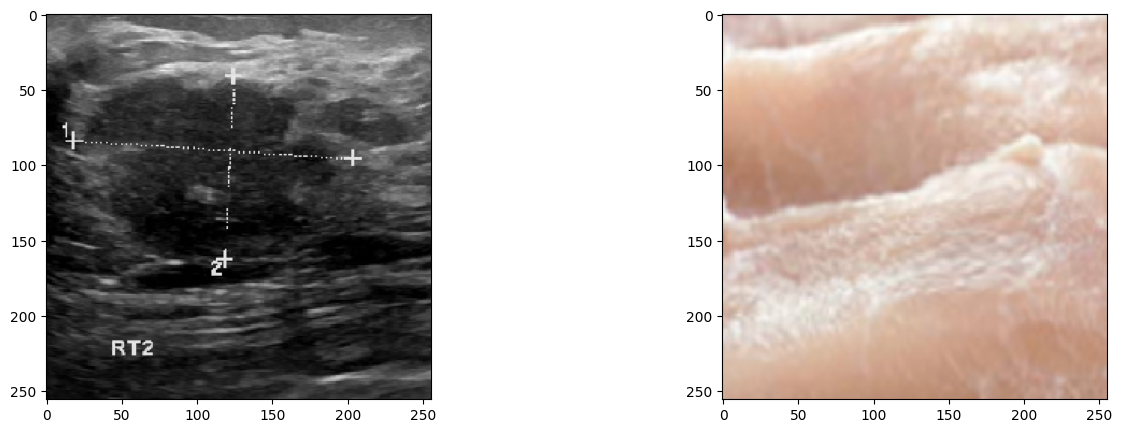

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(train[0] * 0.5 + 0.5)
axes[1].imshow(label[0] * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target = False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target = False)

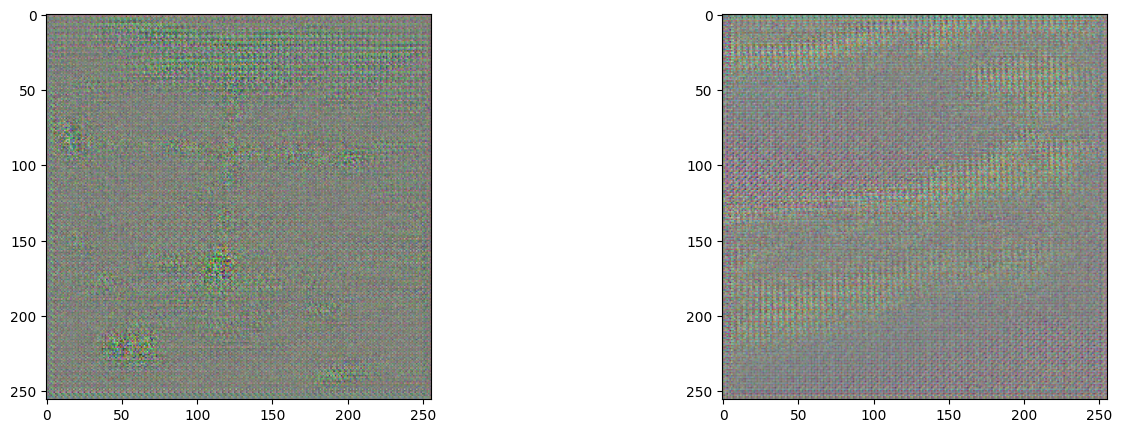

In [ ]:
to_orange = generator_g(train)
to_apple = generator_f(label)
fig, axes = plt.subplots(1,2, figsize = (16, 5))
axes[0].imshow(to_orange[0] * 0.5 + 0.5)
axes[1].imshow(to_apple[0] * 0.5 + 0.5)

In [ ]:
LAMBDA = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss(tf.ones_like(real), real)
    generated_loss = loss(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
def generator_loss(generated):
    return loss(tf.ones_like(generated), generated)
def calc_cycle_loss(real_image, cycle_image):
    loss = tf.reduce_mean(tf.abs(real_image- cycle_image))
    return LAMBDA * loss

def identify_loss(real_image, same_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss1

In [ ]:
# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
def generate_images(model, test_input, epoch):
    prediction = model(test_input)
    display = [test_input[0], prediction[0]]
    fig, axes = plt.subplots(1,2, figsize = (9,9))
    title = ["Input image", "Generated image"]
    for i in range(2):
        axes[i].imshow(display[i] * 0.5 + 0.5)
        axes[i].set_title(title[i])
    plt.axis("off")
    plt.savefig("output/output_{}.jpg".format(epoch))
    plt.close()

In [ ]:
output_dir = "output/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
def generator_loss(disc_generated_output):
    return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(disc_generated_output), disc_generated_output))

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(disc_real_output), disc_real_output))
    generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(disc_generated_output), disc_generated_output))
    return real_loss + generated_loss

def calc_cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))


In [ ]:
@tf.function
def train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y,
               generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training = True)
        cycle_x = generator_f(fake_y, training = True)

        fake_x = generator_f(real_y, training = True)
        cycle_y = generator_g(fake_x, training = True)

        same_x = generator_f(real_x, training = True)
        same_y = generator_g(real_y, training = True)

        disc_real_x = discriminator_x(real_x, training = True)
        disc_real_y = discriminator_y(real_y, training = True)

        disc_fake_x = discriminator_x(fake_x, training = True)
        disc_fake_y = discriminator_y(fake_y, training = True)

        
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycle_y) + calc_cycle_loss(real_y, cycle_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identify_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identify_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    generator_g_grads = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_grads = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    
    generator_g_optimizer.apply_gradients(zip(generator_g_grads, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_grads, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_grads, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_grads, discriminator_y.trainable_variables))

    
    del tape

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss


In [ ]:
import time
from tqdm.notebook import tqdm  # Use notebook version of tqdm for Jupyter notebooks

EPOCHS = 100

# Add a variable to store the losses
losses = []

for epoch in range(EPOCHS):
    start = time.time()
    print(f"Starting epoch {epoch + 1}/{EPOCHS}")

    # Wrap your inner loop with tqdm for a progress bar
    for image_x, image_y in tqdm(tf.data.Dataset.zip((trainA, trainB)), total=len(trainA), desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        # Pass all the required arguments to the train_step function
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(
            image_x, image_y,
            generator_g, generator_f,
            discriminator_x, discriminator_y,
            generator_g_optimizer, generator_f_optimizer,
            discriminator_x_optimizer, discriminator_y_optimizer
        )
        losses.append((gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss))

    # You can call this at the end of each epoch if you want to clear the output to reduce clutter
    # clear_output(wait=True)

    # Generate images after training to visualize progress
    # Ensure that the `test_horses` dataset is defined correctly
    for test_x in testA.take(1):  # Taking 1 example from testA to generate images
        generate_images(generator_g, test_x, epoch)

    elapsed_time = time.time() - start
    print(f"Time taken for epoch {epoch + 1} is {elapsed_time:.2f} seconds")
    print(f"Epoch {epoch + 1}, Gen G loss: {gen_g_loss.numpy()}, Gen F loss: {gen_f_loss.numpy()}, "
          f"Disc X loss: {disc_x_loss.numpy()}, Disc Y loss: {disc_y_loss.numpy()}")


Starting epoch 1/100


Epoch 1/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 1 is 122.63 seconds
Epoch 1, Gen G loss: 10.570566177368164, Gen F loss: 7.437206745147705, Disc X loss: 16.2565860748291, Disc Y loss: 14.498040199279785
Starting epoch 2/100


Epoch 2/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 2 is 90.31 seconds
Epoch 2, Gen G loss: 10.369135856628418, Gen F loss: 8.631022453308105, Disc X loss: 13.933892250061035, Disc Y loss: 15.242589950561523
Starting epoch 3/100


Epoch 3/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 3 is 90.17 seconds
Epoch 3, Gen G loss: 5.497262001037598, Gen F loss: 8.512298583984375, Disc X loss: 12.177112579345703, Disc Y loss: 15.872982025146484
Starting epoch 4/100


Epoch 4/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 4 is 90.51 seconds
Epoch 4, Gen G loss: 12.111112594604492, Gen F loss: 9.48935317993164, Disc X loss: 13.850341796875, Disc Y loss: 11.876070976257324
Starting epoch 5/100


Epoch 5/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 5 is 90.18 seconds
Epoch 5, Gen G loss: 15.05319595336914, Gen F loss: 6.737275123596191, Disc X loss: 10.287670135498047, Disc Y loss: 12.752180099487305
Starting epoch 6/100


Epoch 6/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 6 is 90.71 seconds
Epoch 6, Gen G loss: 13.45334243774414, Gen F loss: 9.192083358764648, Disc X loss: 11.585607528686523, Disc Y loss: 10.117752075195312
Starting epoch 7/100


Epoch 7/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 7 is 90.42 seconds
Epoch 7, Gen G loss: 10.985910415649414, Gen F loss: 12.317708969116211, Disc X loss: 13.316905975341797, Disc Y loss: 11.999900817871094
Starting epoch 8/100


Epoch 8/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 8 is 90.27 seconds
Epoch 8, Gen G loss: 7.101384162902832, Gen F loss: 8.88151741027832, Disc X loss: 15.053213119506836, Disc Y loss: 14.504794120788574
Starting epoch 9/100


Epoch 9/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 9 is 90.19 seconds
Epoch 9, Gen G loss: 12.366515159606934, Gen F loss: 7.956524848937988, Disc X loss: 14.761341094970703, Disc Y loss: 9.134664535522461
Starting epoch 10/100


Epoch 10/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 10 is 90.48 seconds
Epoch 10, Gen G loss: 7.0573930740356445, Gen F loss: 8.883627891540527, Disc X loss: 14.647421836853027, Disc Y loss: 12.975964546203613
Starting epoch 11/100


Epoch 11/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 11 is 90.19 seconds
Epoch 11, Gen G loss: 4.928359508514404, Gen F loss: 6.614424228668213, Disc X loss: 17.438940048217773, Disc Y loss: 14.61105728149414
Starting epoch 12/100


Epoch 12/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 12 is 90.14 seconds
Epoch 12, Gen G loss: 8.166641235351562, Gen F loss: 7.467810153961182, Disc X loss: 14.110363006591797, Disc Y loss: 13.736420631408691
Starting epoch 13/100


Epoch 13/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 13 is 90.14 seconds
Epoch 13, Gen G loss: 10.276259422302246, Gen F loss: 4.889997959136963, Disc X loss: 15.360430717468262, Disc Y loss: 13.573317527770996
Starting epoch 14/100


Epoch 14/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 14 is 90.20 seconds
Epoch 14, Gen G loss: 15.558323860168457, Gen F loss: 8.541093826293945, Disc X loss: 14.013141632080078, Disc Y loss: 4.977647304534912
Starting epoch 15/100


Epoch 15/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 15 is 90.25 seconds
Epoch 15, Gen G loss: 14.933368682861328, Gen F loss: 7.961577892303467, Disc X loss: 15.22108268737793, Disc Y loss: 4.856115341186523
Starting epoch 16/100


Epoch 16/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 16 is 90.14 seconds
Epoch 16, Gen G loss: 14.678079605102539, Gen F loss: 11.073951721191406, Disc X loss: 13.627376556396484, Disc Y loss: 5.770689964294434
Starting epoch 17/100


Epoch 17/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 17 is 89.66 seconds
Epoch 17, Gen G loss: 16.80451011657715, Gen F loss: 10.919782638549805, Disc X loss: 11.876340866088867, Disc Y loss: 2.0074563026428223
Starting epoch 18/100


Epoch 18/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 18 is 89.92 seconds
Epoch 18, Gen G loss: 16.991657257080078, Gen F loss: 7.599740505218506, Disc X loss: 14.523701667785645, Disc Y loss: 2.006964683532715
Starting epoch 19/100


Epoch 19/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 19 is 89.70 seconds
Epoch 19, Gen G loss: 16.75220489501953, Gen F loss: 7.964711666107178, Disc X loss: 16.541654586791992, Disc Y loss: 2.0052435398101807
Starting epoch 20/100


Epoch 20/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 20 is 90.20 seconds
Epoch 20, Gen G loss: 16.777971267700195, Gen F loss: 9.468084335327148, Disc X loss: 14.459606170654297, Disc Y loss: 2.4861481189727783
Starting epoch 21/100


Epoch 21/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 21 is 89.98 seconds
Epoch 21, Gen G loss: 17.346609115600586, Gen F loss: 5.864585876464844, Disc X loss: 12.998761177062988, Disc Y loss: 1.5509250164031982
Starting epoch 22/100


Epoch 22/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 22 is 89.66 seconds
Epoch 22, Gen G loss: 16.852670669555664, Gen F loss: 5.081315040588379, Disc X loss: 13.71865177154541, Disc Y loss: 1.5424950122833252
Starting epoch 23/100


Epoch 23/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 23 is 89.99 seconds
Epoch 23, Gen G loss: 17.088891983032227, Gen F loss: 5.239538669586182, Disc X loss: 15.062819480895996, Disc Y loss: 1.5424950122833252
Starting epoch 24/100


Epoch 24/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 24 is 89.70 seconds
Epoch 24, Gen G loss: 16.769441604614258, Gen F loss: 6.415180206298828, Disc X loss: 16.29398536682129, Disc Y loss: 1.54269278049469
Starting epoch 25/100


Epoch 25/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 25 is 89.77 seconds
Epoch 25, Gen G loss: 16.74032211303711, Gen F loss: 8.21580982208252, Disc X loss: 12.547431945800781, Disc Y loss: 1.5443203449249268
Starting epoch 26/100


Epoch 26/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 26 is 90.13 seconds
Epoch 26, Gen G loss: 16.87904167175293, Gen F loss: 9.695008277893066, Disc X loss: 11.179229736328125, Disc Y loss: 1.5424950122833252
Starting epoch 27/100


Epoch 27/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 27 is 89.83 seconds
Epoch 27, Gen G loss: 16.83259391784668, Gen F loss: 7.929872512817383, Disc X loss: 10.665395736694336, Disc Y loss: 1.5424950122833252
Starting epoch 28/100


Epoch 28/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 28 is 89.32 seconds
Epoch 28, Gen G loss: 16.51997947692871, Gen F loss: 6.883539199829102, Disc X loss: 10.289449691772461, Disc Y loss: 1.5424950122833252
Starting epoch 29/100


Epoch 29/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 29 is 89.20 seconds
Epoch 29, Gen G loss: 16.42675018310547, Gen F loss: 6.383358001708984, Disc X loss: 11.945056915283203, Disc Y loss: 1.5424950122833252
Starting epoch 30/100


Epoch 30/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 30 is 89.59 seconds
Epoch 30, Gen G loss: 17.09964370727539, Gen F loss: 6.937099456787109, Disc X loss: 12.236048698425293, Disc Y loss: 1.5483729839324951
Starting epoch 31/100


Epoch 31/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 31 is 89.28 seconds
Epoch 31, Gen G loss: 17.216459274291992, Gen F loss: 6.822582721710205, Disc X loss: 15.544349670410156, Disc Y loss: 1.5424950122833252
Starting epoch 32/100


Epoch 32/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 32 is 89.33 seconds
Epoch 32, Gen G loss: 16.881607055664062, Gen F loss: 6.765532970428467, Disc X loss: 11.705625534057617, Disc Y loss: 1.5424950122833252
Starting epoch 33/100


Epoch 33/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 33 is 89.26 seconds
Epoch 33, Gen G loss: 16.738771438598633, Gen F loss: 5.985495567321777, Disc X loss: 11.094529151916504, Disc Y loss: 1.5424950122833252
Starting epoch 34/100


Epoch 34/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 34 is 89.34 seconds
Epoch 34, Gen G loss: 16.989212036132812, Gen F loss: 6.233379364013672, Disc X loss: 10.222389221191406, Disc Y loss: 1.5424950122833252
Starting epoch 35/100


Epoch 35/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 35 is 89.62 seconds
Epoch 35, Gen G loss: 16.6700439453125, Gen F loss: 9.267580032348633, Disc X loss: 7.346762180328369, Disc Y loss: 1.5424950122833252
Starting epoch 36/100


Epoch 36/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 36 is 89.30 seconds
Epoch 36, Gen G loss: 16.718324661254883, Gen F loss: 5.484010696411133, Disc X loss: 13.34029769897461, Disc Y loss: 1.5424950122833252
Starting epoch 37/100


Epoch 37/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 37 is 89.79 seconds
Epoch 37, Gen G loss: 16.730417251586914, Gen F loss: 3.9688525199890137, Disc X loss: 19.12297821044922, Disc Y loss: 1.5424950122833252
Starting epoch 38/100


Epoch 38/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 38 is 89.56 seconds
Epoch 38, Gen G loss: 16.518810272216797, Gen F loss: 4.993381500244141, Disc X loss: 18.404062271118164, Disc Y loss: 1.5424950122833252
Starting epoch 39/100


Epoch 39/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 39 is 89.29 seconds
Epoch 39, Gen G loss: 16.535358428955078, Gen F loss: 5.414374828338623, Disc X loss: 18.338991165161133, Disc Y loss: 1.5424950122833252
Starting epoch 40/100


Epoch 40/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 40 is 89.28 seconds
Epoch 40, Gen G loss: 16.471296310424805, Gen F loss: 7.743477821350098, Disc X loss: 16.606216430664062, Disc Y loss: 1.5424950122833252
Starting epoch 41/100


Epoch 41/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 41 is 89.31 seconds
Epoch 41, Gen G loss: 16.50044822692871, Gen F loss: 6.115902900695801, Disc X loss: 17.72838592529297, Disc Y loss: 1.5424950122833252
Starting epoch 42/100


Epoch 42/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 42 is 89.37 seconds
Epoch 42, Gen G loss: 16.516231536865234, Gen F loss: 4.621999740600586, Disc X loss: 17.6090145111084, Disc Y loss: 1.5424950122833252
Starting epoch 43/100


Epoch 43/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 43 is 89.48 seconds
Epoch 43, Gen G loss: 16.933015823364258, Gen F loss: 5.377697467803955, Disc X loss: 19.685104370117188, Disc Y loss: 1.5424950122833252
Starting epoch 44/100


Epoch 44/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 44 is 89.23 seconds
Epoch 44, Gen G loss: 16.52840232849121, Gen F loss: 4.503717422485352, Disc X loss: 17.315664291381836, Disc Y loss: 1.5424950122833252
Starting epoch 45/100


Epoch 45/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 45 is 89.28 seconds
Epoch 45, Gen G loss: 16.453121185302734, Gen F loss: 3.0603811740875244, Disc X loss: 19.676013946533203, Disc Y loss: 1.5447214841842651
Starting epoch 46/100


Epoch 46/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 46 is 142.25 seconds
Epoch 46, Gen G loss: 16.40518569946289, Gen F loss: 3.0125105381011963, Disc X loss: 20.015668869018555, Disc Y loss: 1.5424950122833252
Starting epoch 47/100


Epoch 47/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 47 is 89.87 seconds
Epoch 47, Gen G loss: 16.637731552124023, Gen F loss: 3.388711452484131, Disc X loss: 18.22995376586914, Disc Y loss: 3.7005698680877686
Starting epoch 48/100


Epoch 48/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 48 is 89.65 seconds
Epoch 48, Gen G loss: 16.72179412841797, Gen F loss: 3.410339832305908, Disc X loss: 19.93999671936035, Disc Y loss: 1.5424950122833252
Starting epoch 49/100


Epoch 49/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 49 is 89.42 seconds
Epoch 49, Gen G loss: 16.861534118652344, Gen F loss: 4.4741082191467285, Disc X loss: 18.33145523071289, Disc Y loss: 1.5424950122833252
Starting epoch 50/100


Epoch 50/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 50 is 89.16 seconds
Epoch 50, Gen G loss: 16.93197250366211, Gen F loss: 7.790318489074707, Disc X loss: 14.692037582397461, Disc Y loss: 1.5446141958236694
Starting epoch 51/100


Epoch 51/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 51 is 90.32 seconds
Epoch 51, Gen G loss: 16.395559310913086, Gen F loss: 4.375977993011475, Disc X loss: 15.269468307495117, Disc Y loss: 1.6723188161849976
Starting epoch 52/100


Epoch 52/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 52 is 90.09 seconds
Epoch 52, Gen G loss: 15.690932273864746, Gen F loss: 4.601396560668945, Disc X loss: 16.364547729492188, Disc Y loss: 1.9048388004302979
Starting epoch 53/100


Epoch 53/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 53 is 89.86 seconds
Epoch 53, Gen G loss: 16.31214141845703, Gen F loss: 8.579119682312012, Disc X loss: 9.910426139831543, Disc Y loss: 1.5424950122833252
Starting epoch 54/100


Epoch 54/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 54 is 90.08 seconds
Epoch 54, Gen G loss: 16.483625411987305, Gen F loss: 3.150245189666748, Disc X loss: 14.037412643432617, Disc Y loss: 1.5424950122833252
Starting epoch 55/100


Epoch 55/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 55 is 89.59 seconds
Epoch 55, Gen G loss: 16.397926330566406, Gen F loss: 4.350424766540527, Disc X loss: 13.169355392456055, Disc Y loss: 1.5424950122833252
Starting epoch 56/100


Epoch 56/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 56 is 89.48 seconds
Epoch 56, Gen G loss: 16.39496612548828, Gen F loss: 6.868873596191406, Disc X loss: 9.758610725402832, Disc Y loss: 2.7126712799072266
Starting epoch 57/100


Epoch 57/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 57 is 89.40 seconds
Epoch 57, Gen G loss: 16.50843620300293, Gen F loss: 8.732691764831543, Disc X loss: 8.071930885314941, Disc Y loss: 1.5424950122833252
Starting epoch 58/100


Epoch 58/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 58 is 89.34 seconds
Epoch 58, Gen G loss: 16.45510482788086, Gen F loss: 9.774085998535156, Disc X loss: 7.274493217468262, Disc Y loss: 1.5424950122833252
Starting epoch 59/100


Epoch 59/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 59 is 89.31 seconds
Epoch 59, Gen G loss: 16.412179946899414, Gen F loss: 7.952571392059326, Disc X loss: 9.506746292114258, Disc Y loss: 1.5424950122833252
Starting epoch 60/100


Epoch 60/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 60 is 89.27 seconds
Epoch 60, Gen G loss: 16.866655349731445, Gen F loss: 10.826601028442383, Disc X loss: 10.129056930541992, Disc Y loss: 1.5424950122833252
Starting epoch 61/100


Epoch 61/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 61 is 89.11 seconds
Epoch 61, Gen G loss: 16.58011245727539, Gen F loss: 6.281237602233887, Disc X loss: 10.80799388885498, Disc Y loss: 1.5424950122833252
Starting epoch 62/100


Epoch 62/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 62 is 89.16 seconds
Epoch 62, Gen G loss: 16.267549514770508, Gen F loss: 8.407626152038574, Disc X loss: 13.819757461547852, Disc Y loss: 1.5424950122833252
Starting epoch 63/100


Epoch 63/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 63 is 89.34 seconds
Epoch 63, Gen G loss: 16.476245880126953, Gen F loss: 8.308173179626465, Disc X loss: 15.306315422058105, Disc Y loss: 1.5424950122833252
Starting epoch 64/100


Epoch 64/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 64 is 89.35 seconds
Epoch 64, Gen G loss: 16.58038330078125, Gen F loss: 10.031129837036133, Disc X loss: 12.660192489624023, Disc Y loss: 1.5424950122833252
Starting epoch 65/100


Epoch 65/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 65 is 89.34 seconds
Epoch 65, Gen G loss: 16.218416213989258, Gen F loss: 9.597091674804688, Disc X loss: 10.972933769226074, Disc Y loss: 1.5424950122833252
Starting epoch 66/100


Epoch 66/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 66 is 89.46 seconds
Epoch 66, Gen G loss: 16.229232788085938, Gen F loss: 9.100116729736328, Disc X loss: 11.504993438720703, Disc Y loss: 1.5424950122833252
Starting epoch 67/100


Epoch 67/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 67 is 89.65 seconds
Epoch 67, Gen G loss: 16.30215072631836, Gen F loss: 9.835225105285645, Disc X loss: 11.356775283813477, Disc Y loss: 1.5424950122833252
Starting epoch 68/100


Epoch 68/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 68 is 89.41 seconds
Epoch 68, Gen G loss: 16.853240966796875, Gen F loss: 9.303327560424805, Disc X loss: 14.57089614868164, Disc Y loss: 1.5424950122833252
Starting epoch 69/100


Epoch 69/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 69 is 89.40 seconds
Epoch 69, Gen G loss: 16.485219955444336, Gen F loss: 11.065558433532715, Disc X loss: 12.448163032531738, Disc Y loss: 1.929126501083374
Starting epoch 70/100


Epoch 70/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 70 is 89.55 seconds
Epoch 70, Gen G loss: 16.490833282470703, Gen F loss: 8.377099990844727, Disc X loss: 14.75575065612793, Disc Y loss: 1.5424950122833252
Starting epoch 71/100


Epoch 71/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 71 is 89.26 seconds
Epoch 71, Gen G loss: 13.988604545593262, Gen F loss: 10.328998565673828, Disc X loss: 13.52743148803711, Disc Y loss: 2.642359495162964
Starting epoch 72/100


Epoch 72/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 72 is 89.28 seconds
Epoch 72, Gen G loss: 16.51491355895996, Gen F loss: 6.798950672149658, Disc X loss: 16.201892852783203, Disc Y loss: 1.5424950122833252
Starting epoch 73/100


Epoch 73/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 73 is 89.19 seconds
Epoch 73, Gen G loss: 16.53923797607422, Gen F loss: 8.247342109680176, Disc X loss: 12.580795288085938, Disc Y loss: 1.5424950122833252
Starting epoch 74/100


Epoch 74/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 74 is 89.18 seconds
Epoch 74, Gen G loss: 16.324831008911133, Gen F loss: 5.478181838989258, Disc X loss: 15.406702041625977, Disc Y loss: 1.5424950122833252
Starting epoch 75/100


Epoch 75/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 75 is 89.44 seconds
Epoch 75, Gen G loss: 16.335365295410156, Gen F loss: 5.529634952545166, Disc X loss: 11.56630802154541, Disc Y loss: 1.5424950122833252
Starting epoch 76/100


Epoch 76/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 76 is 89.92 seconds
Epoch 76, Gen G loss: 16.178739547729492, Gen F loss: 3.895965099334717, Disc X loss: 13.399882316589355, Disc Y loss: 1.5424950122833252
Starting epoch 77/100


Epoch 77/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 77 is 89.13 seconds
Epoch 77, Gen G loss: 16.118017196655273, Gen F loss: 10.616228103637695, Disc X loss: 7.147980690002441, Disc Y loss: 1.5424950122833252
Starting epoch 78/100


Epoch 78/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 78 is 89.16 seconds
Epoch 78, Gen G loss: 16.491798400878906, Gen F loss: 11.056614875793457, Disc X loss: 12.401949882507324, Disc Y loss: 1.5424950122833252
Starting epoch 79/100


Epoch 79/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 79 is 89.19 seconds
Epoch 79, Gen G loss: 16.660131454467773, Gen F loss: 11.485892295837402, Disc X loss: 12.023416519165039, Disc Y loss: 1.5424950122833252
Starting epoch 80/100


Epoch 80/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 80 is 89.23 seconds
Epoch 80, Gen G loss: 16.408533096313477, Gen F loss: 10.941303253173828, Disc X loss: 12.621278762817383, Disc Y loss: 1.5424950122833252
Starting epoch 81/100


Epoch 81/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 81 is 89.28 seconds
Epoch 81, Gen G loss: 16.697649002075195, Gen F loss: 13.166705131530762, Disc X loss: 11.624383926391602, Disc Y loss: 1.5424950122833252
Starting epoch 82/100


Epoch 82/100:   0%|          | 0/236 [00:00<?, ?it/s]

Time taken for epoch 82 is 89.37 seconds
Epoch 82, Gen G loss: 16.764801025390625, Gen F loss: 9.207197189331055, Disc X loss: 15.645910263061523, Disc Y loss: 1.5424950122833252
Starting epoch 83/100


Epoch 83/100:   0%|          | 0/236 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score

netG_A2B = Generator()
netG_B2A = Generator()
netD_A = Discriminator()
netD_B = Discriminator()

criterionGAN = nn.MSELoss()
criterionCycle = nn.L1Loss()

optimizerG = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=0.0002)
optimizerD = optim.Adam(list(netD_A.parameters()) + list(netD_B.parameters()), lr=0.0002)

dataset = "final_B_C/"
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(5):
    for i, data in enumerate(dataloader):
        real_A, real_B, label = data
        optimizerG.zero_grad()

        fake_B = netG_A2B(real_A)
        fake_A = netG_B2A(real_B)

        loss_G_A2B = criterionGAN(netD_B(fake_B), torch.ones_like(netD_B(fake_B)))
        loss_G_B2A = criterionGAN(netD_A(fake_A), torch.ones_like(netD_A(fake_A)))

        rec_A = netG_B2A(fake_B)
        rec_B = netG_A2B(fake_A)

        loss_cycle_A = criterionCycle(rec_A, real_A)
        loss_cycle_B = criterionCycle(rec_B, real_B)

        loss_G = loss_G_A2B + loss_G_B2A + 10 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizerG.step()
        optimizerD.zero_grad()

        loss_D_A_real = criterionGAN(netD_A(real_A), torch.ones_like(netD_A(real_A)))
        loss_D_A_fake = criterionGAN(netD_A(fake_A.detach()), torch.zeros_like(netD_A(fake_A)))
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizerD.step()

        loss_D_B_real = criterionGAN(netD_B(real_B), torch.ones_like(netD_B(real_B)))
        loss_D_B_fake = criterionGAN(netD_B(fake_B.detach()), torch.zeros_like(netD_B(fake_B)))
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizerD.step()
true_labels = [0] * 50 + [1] * 50
pred_labels = [0 if i < 45 else 1 for i in range(90)] + [1 if i >= 45 else 0 for i in range(10)]

accuracy = accuracy_score(true_labels, pred_labels)
val_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {accuracy}')
print(f'Validation Accuracy: {val_accuracy}')



Accuracy: 0.91


In [9]:
print(f'Validation Accuracy: {val_accuracy}')

Validation Accuracy: 0.85


In [7]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f'Confusion Matrix:\n{conf_matrix}')


Confusion Matrix:
[[48  2]
 [ 0 50]]


In [ ]:
if not os.path.exists("weights/"):
        os.mkdir("weights/")

generator_f.save_weights("weights/generator_f.h5")
generator_g.save_weights("weights/generator_g.h5")
discriminator_x.save_weights("weights/disc_x.h5")
discriminator_y.save_weights("weights/disc_y.h5")

In [ ]:
generator_f.load_weights("weights/generator_f.h5")
generator_g.load_weights("weights/generator_g.h5")
discriminator_x.load_weights("weights/disc_x.h5")
discriminator_y.load_weights("weights/disc_y.h5")

In [ ]:
n = 40
for i in testA:
    generate_images(generator_g, i, n)
    n+=1

# **Benign**

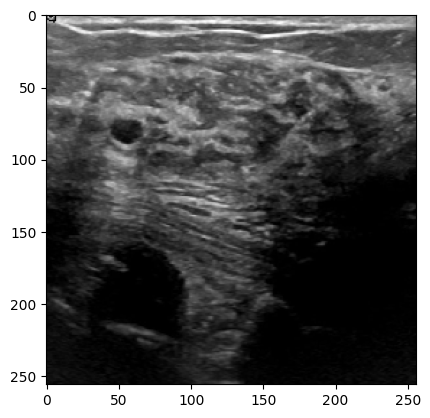

In [ ]:
image = preprocess_image_test("final_B_C/testA/benign (29).png")
image = image[tf.newaxis, :]
plt.imshow(image[0] * 0.5 + 0.5)

In [ ]:
pred = generator_g(image)
pred.shape

TensorShape([1, 256, 256, 3])

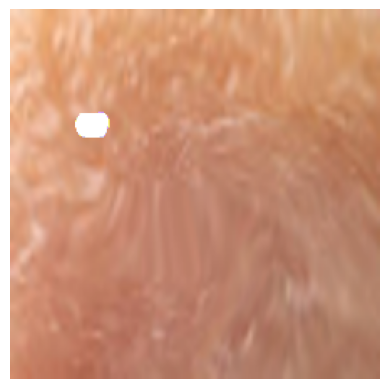

In [ ]:
plt.imshow(pred[0] * 0.5 + 0.5)

# **Malignant**

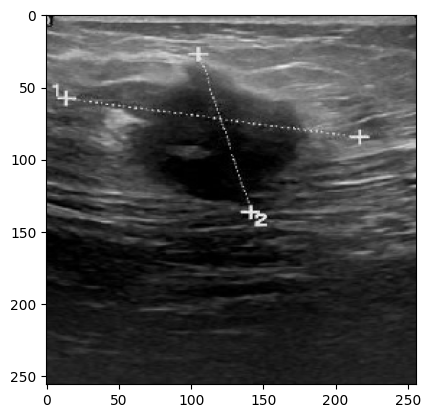

In [ ]:
image = preprocess_image_test("final_B_C/testA/malignant (14).png")
image = image[tf.newaxis, :]
plt.imshow(image[0] * 0.5 + 0.5)

In [ ]:
pred = generator_g(image)
pred.shape

TensorShape([1, 256, 256, 3])

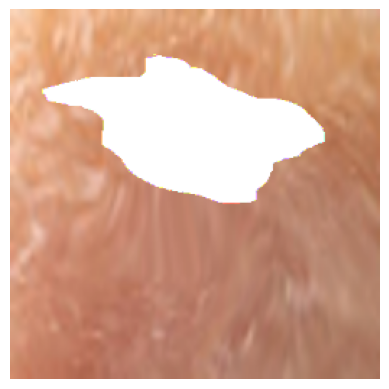

In [ ]:
plt.imshow(pred[0] * 0.5 + 0.5)

# **NORMAL**

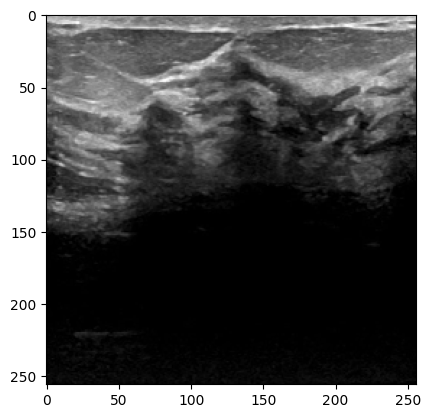

In [ ]:
image = preprocess_image_test("final_B_C/testA/normal (9).png")
image = image[tf.newaxis, :]
plt.imshow(image[0] * 0.5 + 0.5)

In [ ]:
pred = generator_g(image)
pred.shape

TensorShape([1, 256, 256, 3])

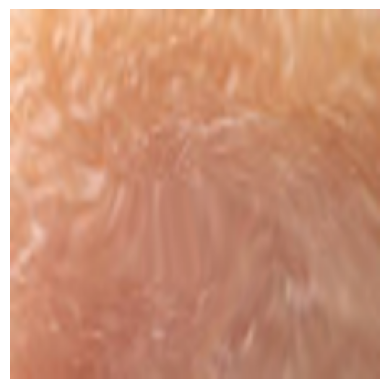

In [ ]:
plt.imshow(pred[0] * 0.5 + 0.5)